## Домашнее задание 3

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.
2. Подберите параметры модели SARIMAX для этого ряда.
3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_m = data.resample('M').mean()

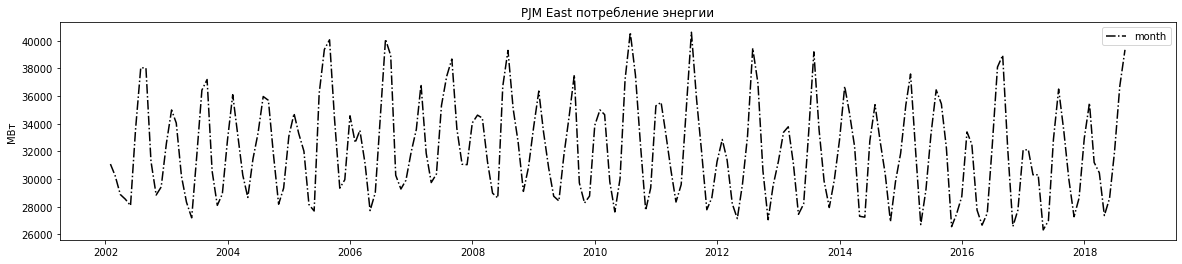

In [19]:
plt.figure(figsize =(20,4))
plt.plot( data_m.index[:], data_m['PJME_MW'].values[:], '-.k',label='month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

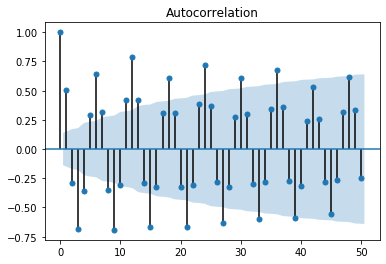

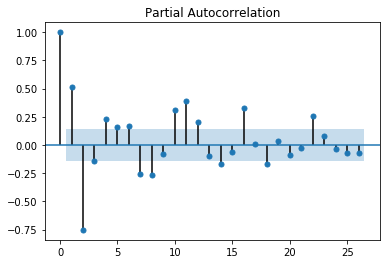

In [5]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=50)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

По первым разностям определим коэффициент для модели AR = 3, по графику автокорелляции выставим параметр для модели МА = 36, сезонность - 12 месяцев

In [6]:
p = 3
d = 2
q = 36
pdq = [p, d, q]

ps = 0
ds = 1
qs = 1
seasonal_pdq = [ps, ds, qs, 12] 

In [7]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[3, 2, 36]x[0, 1, 1, 12] - AIC:2246.6377514620417


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                  Statespace Model Results                                 
Dep. Variable:                                   y   No. Observations:                  188
Model:             SARIMAX(3, 2, 36)x(0, 1, 1, 12)   Log Likelihood               -1082.319
Date:                             Thu, 23 Jan 2020   AIC                           2246.638
Time:                                     00:25:10   BIC                           2362.599
Sample:                                          0   HQIC                          2293.747
                                             - 188                                         
Covariance Type:                               opg                                         
=========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

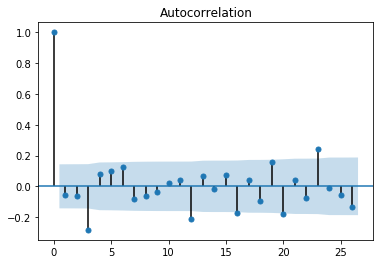

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=26)
plt.show()

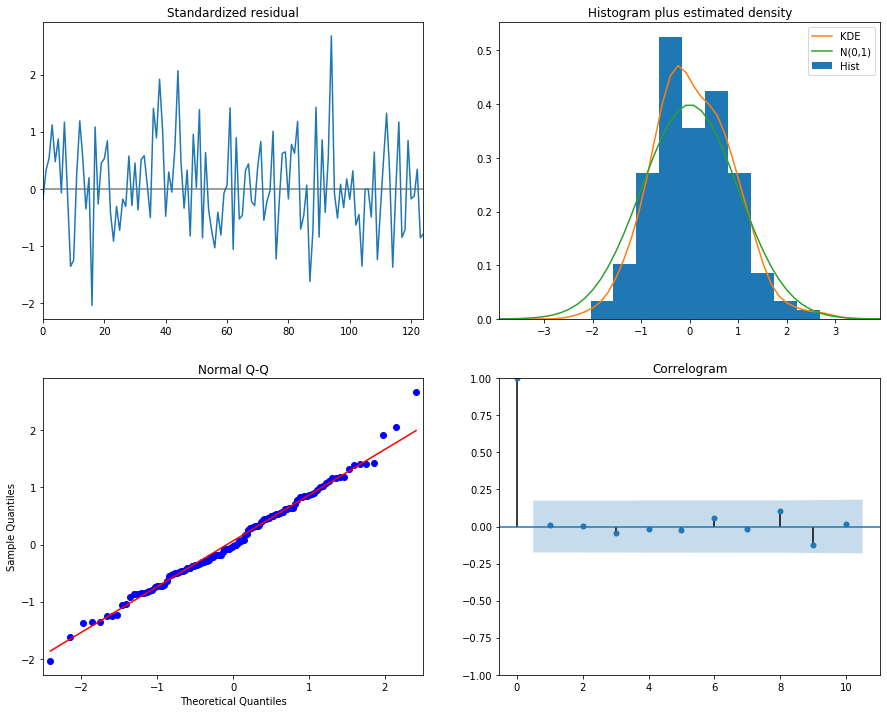

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Выводы**

В остатках еще присутствует небольшая автокорелляция по графикам так же заметно, что существует провал значений вблизи нуля (график KDE), хотя распределение, судя по обоим графикам близко к нормальному
По таблице model results видим, что после коэффициента L21, модули коэффициентов упали.

Попробуем подобрать модель программно

In [11]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
warnings.filterwarnings("ignore") # отключает предупреждения

best_model = [0, 0]
to_compare = 1e10
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-20],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < to_compare:
                to_compare = results.aic
                best_model[0] = param
                best_model[1] = param_seasonal
                print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4227.9447887503375
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:3833.0117432165875
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3533.566394478643
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3005.685326512251
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2780.9839130091423
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2548.56501744726
ARIMA(0, 0, 0)x(0, 2, 2, 12)3 - AIC:2424.386371710624
ARIMA(0, 0, 0)x(1, 2, 2, 12)3 - AIC:2420.9223275136674
ARIMA(0, 0, 0)x(2, 2, 2, 12)3 - AIC:2402.305817301286
ARIMA(0, 0, 1)x(1, 2, 2, 12)3 - AIC:2382.725784376308
ARIMA(0, 0, 1)x(2, 2, 2, 12)3 - AIC:2364.28090470763
ARIMA(0, 0, 2)x(2, 2, 2, 12)3 - AIC:2346.0701119984033
ARIMA(0, 1, 1)x(1, 2, 2, 12)3 - AIC:2329.6720364671946
ARIMA(0, 1, 1)x(2, 2, 2, 12)3 - AIC:2327.197000715835
ARIMA(0, 1, 2)x(0, 2, 2, 12)3 - AIC:2299.3068238212527
ARIMA(1, 1, 2)x(0, 2, 2, 12)3 - AIC:2296.646191931063


In [16]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[1,1,2],
                                seasonal_order=[0,2,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto = mod.fit()
print('AIC:{}',results_auto.aic)

AIC:{} 2516.490462294343


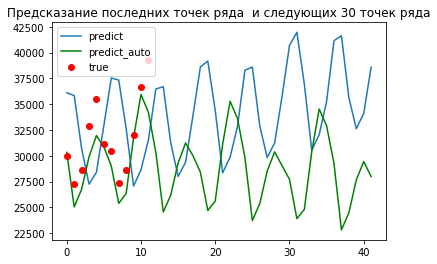

In [18]:
pred_dynamic = results.forecast(42)
pred_dynamic_auto = results_auto.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_auto,'g', label='predict_auto' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

Видим, что построенная вручную и подобранная автоматическим методом модели различаются трендом, а также имеют различные амплитуды в сезонах. Судя по значению AIC, вручную подобранная модель лучше обходит известные значения, однако по общему месячному графику (первый в ноутбуке) нельзя сказать, что потребление энергии имеет ярко выраженный положительный тренд. Модель выбранная перебором значений не имеет столь явно выраженного тренда при предсказываний на более длительный промежуток, поэтому есть ощущение, что с этой задачей она справится лучше.
В сравнений с недельной моделью, полученной на уроке, обе модели имеет существенно меньший AIC, а значит ближе приближают функцию правдоподобия, выявляя более общую закономерность